In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from lml import LML

from copy import deepcopy

from model.layers import KHopfield

from model.lml2 import LML2

from matplotlib import pyplot as plt
# set auto reload
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import numpy as np

import pandas as pd



In [3]:
# load mnist, take the build a matrix of all pairwiase distances
# load mnist
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('~/data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('~/data', train=False, download=True, transform=transform)

# load data
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [4]:
# get min and max value in all test data
min_value = 0
max_value = 0
for data, target in test_loader:
    min_value = min(min_value, torch.min(data))
    max_value = max(max_value, torch.max(data))

In [5]:
min_value, max_value

(tensor(-0.4242), tensor(2.8215))

In [6]:
# returns a matrix of pairwaise distances
def pair_wise_distance(dataset, norm = 2):
    # get the number of samples
    n = len(dataset)
    # get the dimension of the data
    d = len(dataset[0][0].flatten())
    # create a matrix to store the distances
    distances = torch.zeros((n, n))
    
    # create a batch loader

    batch_size = 1000
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # iterate over the batches
    
    inner_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (x, _) in tqdm(enumerate(loader), total=len(loader)):
        # compute the distances
        for j, (x2, _) in enumerate(inner_loader):
            # compute the distancetorch.cdist(x, x2, p=norm)
            dists = torch.cdist(x.flatten(start_dim=1), x2.flatten(start_dim=1), p=norm)
            distances[i*batch_size:(i+1)*batch_size, j*batch_size:(j+1)*batch_size] = dists
    return distances

In [7]:
# # compute the pairwise distances of test data
# distances = pair_wise_distance(test_data, norm = 2)

# # # save in data folder
# torch.save(distances, 'data/mnist_test_distances_l1.pt')
distances = torch.load('data/mnist_test_distances_l1.pt')

In [8]:
# make a wrapper aroudn mnist dataset
class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, index):
        return self.dataset[index][0].flatten(), self.dataset[index][1], index
    def __len__(self):
        return len(self.dataset)
    
# create a dataset wrapper
test_dataset_w = DatasetWrapper(test_data)
test_loader_w = DataLoader(test_dataset_w, batch_size=1, shuffle=False)


In [9]:

def get_k_retrieval_exp(memories = 1000, p=1, seed=0, batch_size = 1):
    if p == 1:
        distances = torch.load('data/mnist_test_distances_l1.pt')
    elif p == 2:
        distances = torch.load('data/mnist_test_distances_l2.pt')

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    test_data = datasets.MNIST('~/data', train=False, download=True, transform=transform)
    
    # get random subset of indices
    # set seed
    np.random.seed(seed)
    indices = np.random.choice(len(test_data), memories, replace=False)
    
    dataset_subset = Subset(test_data, indices=indices)
    dataset_subset_w = DatasetWrapper(dataset_subset)
    
    test_loader_w = DataLoader(dataset_subset_w, batch_size=batch_size, shuffle=False)

    # get only the rows of the distances matrix where the row and column indices are in indices list
    distances_subset = distances[indices][:, indices]

    # assert diagonal elements of distances_subset are zero
    
    hopfield = KHopfield(memories, 784, p=p)
    hopfield.set_memories_from_loader(test_loader_w)
    return distances_subset, hopfield, test_loader_w

    

In [10]:
# make a hopfield network
distances, hopfield, test_loader_w = get_k_retrieval_exp(memories = 1000, p=1)

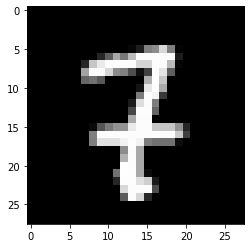

In [11]:
# print first image in test_loader_w
plt.imshow(test_loader_w.dataset[1][0].reshape(28, 28), cmap='gray')

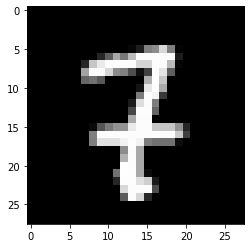

In [12]:
# print first image in memory
plt.imshow(hopfield.memories[1].reshape(28, 28).detach().numpy(), cmap='gray')

In [13]:
hopfield.memories.shape

torch.Size([1000, 784])

In [71]:

def get_k_precission(true_top_k, predicted_top_k):
    # true top_k is a torch tensor batch_size x k
    # predicted top_k is a torch tensor batch_size x k
    # compute the recall which is a b vector
    k = predicted_top_k.shape[1]
    b = predicted_top_k.shape[0]
    # compute the recall
    precision = torch.zeros(b)
    for i in range(b):
        intersection = np.intersect1d(true_top_k[i].numpy(), predicted_top_k[i].numpy())
        precision[i] = len(intersection)/k
    return precision

In [51]:

def get_k_recall(true_top_k, predicted_top_k):
    # true top_k is a torch tensor batch_size x k
    # predicted top_k is a torch tensor batch_size x k
    # compute the recall which is a b vector
    k = true_top_k.shape[1]
    b = true_top_k.shape[0]
    # compute the recall
    recall = torch.zeros(b)
    for i in range(b):
        intersection = np.intersect1d(true_top_k[i].numpy(), predicted_top_k[i].numpy())
        recall[i] = len(intersection)/k
    return recall

In [91]:
def k_recall_exp(test_loader_w, distances, k, seed=0, var=0, beta=1):
    total_seen = 0
    total_k_recall = torch.zeros(k)
    total_k_precision = torch.zeros(k)
    for batch_idx, batch in tqdm(enumerate(test_loader_w), total = len(test_loader_w)):
        x, y, i = batch
        total_seen += len(x)
        # get rows of distance matrix from every element in batch

        # add noise to x
        torch.manual_seed(seed)
        x = x + (torch.randn_like(x) * var)
        # clamp x
        x = torch.clamp(x, -0.4242, 2.8215)

        dists = distances[i]
        
        # get the top k
        top_k = torch.argsort(dists, dim=1)[:, :k]

        # k hopfield
        scores = hopfield(x,  k=k, beta = beta, hopfield_steps=0, index=True)
        reported_argmax = torch.argmax(scores, dim=1)

        # uses simple softmax and argsort
        # scores = hopfield.soft_index(hopfield.memories, x,  beta = beta)
        # reported_argmax = torch.argsort(scores, descending=True, dim=1)[:, :k]


        for j in range(1, k+1):
            # from https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
            # recall@k is the fraction of the k most similar items in the database that are also present in the k most similar items in the result of the query.
            # which looks like precision to me but whatever
            k_precision = get_k_precission(top_k, reported_argmax[:,:j])
            total_k_precision[j-1] += torch.sum(k_precision)

            k_recall = get_k_recall(top_k[:,:j], reported_argmax[:,:j])
            total_k_recall[j-1] += torch.sum(k_recall)

        
    return total_k_recall / total_seen

In [84]:
distances, hopfield, test_loader_w = get_k_retrieval_exp(memories = 1000, p=1,  batch_size =200)

In [97]:
recalls = []
betas = [5, 10, 20, 30]
for beta in betas:
    recall = k_recall_exp(test_loader_w, distances, k=3, var=1, seed= 1, beta=beta)
    recalls.append(recall)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


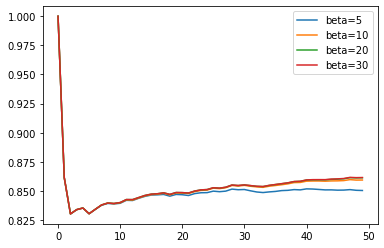

In [96]:
# make precision recall plot   
for i, recall in enumerate(recalls):
    plt.plot(recall, label=f'beta={betas[i]}') 
plt.legend()


In [80]:
# get dists[j,k] where j in i and k in 
variances = [0, .25, .5, .75, 1, 1.25, 1.5]
# make a pandas dataframe to store the results
mean_pd = pd.DataFrame(columns=['variance', 'k', 'recall'])
std_pd = pd.DataFrame(columns=['variance', 'k', 'recall'])

K=50
n_trials = 1
for var in variances:
    print(f"Var: {var}")
    trials = []
    for i in range(n_trials):
        results = k_recall_exp(test_loader_w, distances, k=K, var=var, seed= i)
        trials.append(results)
    mean = torch.mean(torch.stack(trials), dim=0).detach().numpy()
    std = torch.std(torch.stack(trials), dim=0).detach().numpy()

    for k in range(1, K+1):
        mean_pd = mean_pd.append({'variance': var, 'k': k, 'recall': mean[k-1]}, ignore_index=True)
        std_pd = std_pd.append({'variance': var, 'k': k, 'recall': std[k-1]}, ignore_index=True)


Var: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [252]:
# save pd frames
mean_pd.to_csv('data/mean_softmaxonly_beta.5_pd.csv')
std_pd.to_csv('data/std_softmaxonly__beta.5_pd.csv')

In [91]:
mean_pd = pd.read_csv('data/mean_softmaxonly_beta.5_pd.csv')
std_pd = pd.read_csv('data/std_softmaxonly__beta.5_pd.csv')

# find all unique variances and put them in a list
#variances = mean_pd['variance'].unique()

In [44]:
# make a plot of the results 
plt.figure(figsize=(10, 10))
for var in variances:
    plt.plot(mean_pd[mean_pd['variance'] == var]['k'], mean_pd[mean_pd['variance'] == var]['recall'], label='variance: {}'.format(var))
    plt.fill_between(mean_pd[mean_pd['variance'] == var]['k'], mean_pd[mean_pd['variance'] == var]['recall'] - std_pd[std_pd['variance'] == var]['recall'], mean_pd[mean_pd['variance'] == var]['recall'] + std_pd[std_pd['variance'] == var]['recall'], alpha=.1)
plt.legend()
plt.xlabel('k')
plt.ylabel('recall@k')
#font size
plt.rcParams.update({'font.size': 30})


NameError: name 'mean_pd' is not defined

<Figure size 720x720 with 0 Axes>

In [165]:
# save pd frames
mean_pd.to_csv('data/mean_pd.csv')
std_pd.to_csv('data/std_pd.csv')

[tensor([1.0000, 0.9875, 0.9810, 0.9795, 0.9786, 0.9778, 0.9793, 0.9794, 0.9786,
         0.9768, 0.9780, 0.9781, 0.9798, 0.9797, 0.9775, 0.9786, 0.9769, 0.9761,
         0.9758, 0.9758]),
 tensor([1.0000, 0.9820, 0.9790, 0.9783, 0.9758, 0.9772, 0.9780, 0.9779, 0.9777,
         0.9766, 0.9785, 0.9758, 0.9766, 0.9794, 0.9785, 0.9762, 0.9756, 0.9756,
         0.9743, 0.9749])]

In [161]:
# get mean and std of trials
def get_mean_std(trials):
    mean = torch.zeros(len(trials[0]))
    std = torch.zeros(len(trials[0]))
    for i in range(len(trials[0])):
        mean[i] = torch.mean(torch.stack([t[i] for t in trials]))
        std[i] = torch.std(torch.stack([t[i] for t in trials]))
    return mean, std


In [166]:
get_mean_std(trials)

(tensor([1.0000, 0.9848, 0.9800, 0.9789, 0.9772, 0.9775, 0.9786, 0.9786, 0.9781,
         0.9767, 0.9782, 0.9769, 0.9782, 0.9795, 0.9780, 0.9774, 0.9762, 0.9758,
         0.9750, 0.9754]),
 tensor([0.0000, 0.0039, 0.0014, 0.0009, 0.0020, 0.0005, 0.0009, 0.0011, 0.0006,
         0.0001, 0.0003, 0.0016, 0.0022, 0.0003, 0.0007, 0.0017, 0.0009, 0.0004,
         0.0011, 0.0006]))

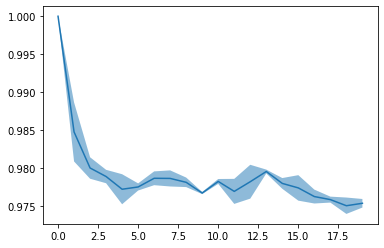

In [167]:
# plot the mean and std
mean, std = get_mean_std(trials)
plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=.5)